In [1]:
# preliminaries: let's load some stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

# More than a sum of parts: network computing with neurons

One of the most important ideas in theoretical neuroscience is the (surprising) finding that brains are more than just a collection of the computations performed by individual neurons. This is partly because the properties we think of as "single neuron" computations are often the byproduct of network effects. But it is also reflective of a deeper truth: **nonlinearity and recurrence** unlock powerful computational capabilities in networks.  

Let's unpack that a bit. 

## Linearity and its discontents

First off, **nonlinearity** describes any phenomenon which is, well, _not linear_. So what does linear mean? Mostly this: if we make the input to a system twice as strong, the response of the system will scale in proportion. So, if we're thinking of input-ouput functions of neurons, we'd get something like:

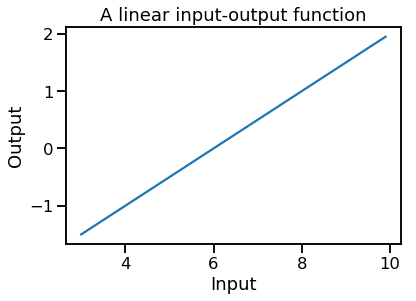

In [3]:
input_range = np.arange(3, 10, 0.1)
plt.plot(input_range, 0.5 * input_range - 3)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('A linear input-output function');

So far so good. But as we know, _neurons_ don't have negative outputs. Their input-output functions look more like this:

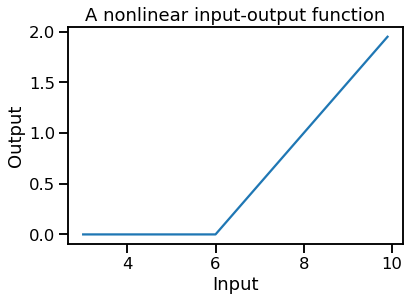

In [5]:
plt.plot(input_range, np.maximum(0.5 * input_range - 3, 0))
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('A nonlinear input-output function');

Notice something really interesting: Even though this function is linear for inputs > 6, it is _nonlinear_ over all. It's a very, very mild nonlinearity, but that's enough for fascinating things to happen. 

In the next section, we'll discuss why.

## Composition and recurrence

One of the mathematically nicest but also most limiting features of linear systems is that when we **compose** linear systems (feeding the output of one into another), _they remain linear_. Using lots of linear building blocks in sequence doesn't really buy us more than having one giant linear system.

![boring](https://media1.tenor.com/images/b278a5a006340b8946457552adec56c5/tenor.gif?itemid=7991240)

But when we compose nonlinear systems, magic happens! In fact, if we take three sets of neurons &mdash; an input layer, a middle (often called hidden) layer, and an output layer &mdash; this is enough to approximate **any** function.

![title](http://www.quickmeme.com/img/a7/a78ae76da19c1a0f9e0e9b2f7e6229e70bd36cf7bc5b2f29b5f8900face50234.jpg)

But there's another idea we might have: what if we feed the output of a system (linear or nonlinear) _back into itself_? We call that idea **recurrence**, and it's also incredibly powerful. In fact, recurrent linear systems do some pretty cool things, but recurrent nonlinear systems have can have really, really complex behavior.

![nonlinear-brain](https://i.imgflip.com/49k332.jpg)

The rest of this section is about exploring how nonlinearity and recurrence can work together to do something that no collection of isolated neurons can do.

## Hopfield networks